# Predictive Data Mining
IFN645 - Data Mining Technologies and Applications
Due date: 7th April, 2019

Before answering any questions we need to import the neccessary libraries and data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, accuracy_score
df = pd.read_csv('./data.csv')

# Toggle whether or not to show output.
verbose = False
quick_mode = False
target_value = "IsBadBuy"

C:\Users\Schmidt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Task 1 - Data Selection and Distribution. 
#### 1.1 What is the proportion of cars who can be classified as a “kick”?
The proportion of *kicks* can be calculated using the function .mean() because the data is stored binary in the column *IsBadBuy*.  12.95% of the cars are *kicks* in the provided dataset.

In [2]:
if(verbose):
    print("Percentage of kicks: " + str(df[target_value].mean() * 100) + "%")

#### 1.2 Did you have to fix any data quality problems? Detail them.
We found a bunch of data quality problems that we had to take care of.

Almost all data was missing on 44 of the rows, so we decided to remove them from the dataset. The percentage of *kicks* remained 12.95%.

In [3]:
c_name = "VehYear"
df[c_name] = df[c_name].fillna(0).astype(int)
if(verbose):
    print(df.loc[df[c_name] == 0])
df = df[df[c_name] != 0]

Some columns required data cleaning. As we did not have a data/domain expert available we had to make some assumptions:
- *Manual* and *MANUAL* is assumed to be the same in the column *Transmission*.
- All values except 0 and 0.0 is assumed to be 1 in the column *IsOnlineSale*.
- *IsOnlineSale* should be represented as a binary value.
- *IsBadBuy* should be represented as binary value.
- All *MMR...* values should be interpreted as numbers, not strings.
- *WheelType* empty cells should be *?*.

In [4]:
c_name = "Transmission"
if(verbose):
    print(df[c_name].unique())
df[c_name] = df[c_name].mask(df[c_name] == "Manual", "MANUAL")
if(verbose):
    print(df[c_name].unique())
    
c_name = "IsOnlineSale"
if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()

df[c_name] = df[c_name].mask(df[c_name] == 0.0, "0")
df[c_name] = np.where(df[c_name] == "0", False, True)

if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()
    
c_name = "IsBadBuy"
if(verbose):
    df[c_name].unique()
df[c_name] = df[c_name].astype(bool)
if(verbose):
    df[c_name].unique()
    
     
for c_name in ["MMRAcquisitionAuctionAveragePrice",
              "MMRAcquisitionAuctionCleanPrice",
              "MMRAcquisitionRetailAveragePrice",
              "MMRAcquisitonRetailCleanPrice",
              "MMRCurrentAuctionAveragePrice",
              "MMRCurrentAuctionCleanPrice",
              "MMRCurrentRetailAveragePrice",
              "MMRCurrentRetailCleanPrice",
              "MMRCurrentRetailRatio",
              "VehBCost"]:
    df[c_name] = df[c_name].mask(df[c_name] == "?", 0)
    df[c_name] = df[c_name].mask(df[c_name] == "#VALUE!", 0)
    df[c_name] = pd.to_numeric(df[c_name])
    df[c_name] = df[c_name].mask(df[c_name] == 1, 0)
    
c_name = "WheelType"
df[c_name] = df[c_name].fillna("?")

#### 1.3 Can you identify any clear patterns by initial exploration of the data using histogram or box plot?
The *VehYear* column, the year in which the car was made - does seems to have a influence on the *IsBadBuy* varible.  
It is more likely that an older car is a *kick*.

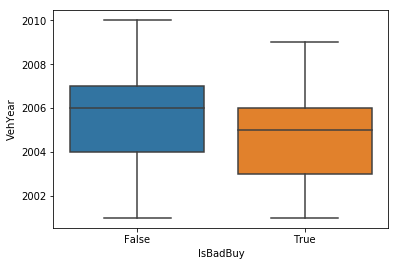

In [5]:
ax = sns.boxplot(x=target_value, y='VehYear', data=df)
plt.show()

#### 1.4 What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
We decided to drop the following columns:
- PurchaseID
- PurchaseTimestamp
- PurchasseData
- WheelTypeID
- PRIMEUNIT
- AUCGUART
- ForSale

Identification columns is not interesting. Almost all cars are marked as for sale. *PRIMEUNIT* and *AUCGUART* is missing data in most of the data entries.

In [6]:
df.drop(['PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID','PRIMEUNIT','AUCGUART','ForSale'],axis=1,inplace=True)

#### 1.5 What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection.
The distribution between good and bad buys was very skewed, which made our prediction models have a heavy tendency to predict most cars as being good buys. We decided to use undersampling to counter the skewness - so the distribution between good and bay buys were equal in our traning sets.

## Task 2 - Predictive Modeling Using Decision Trees

In [7]:
# prepare data for decision tree
df_decision = pd.get_dummies(df)
df_decision = df_decision.dropna()

# target/input split
y = df_decision[target_value]
X = df_decision.drop([target_value],axis = 1)

# setting random state
rs = 10

# undersampling 
badBuy_indices = df_decision[df_decision[target_value] == 0].index

sample_size = sum(df_decision.IsBadBuy == 1)

random_indices = np.random.choice(badBuy_indices, sample_size, replace=False)

Non_badBuy_sample = df_decision.loc[random_indices]

Badbuys = df_decision.loc[df_decision[target_value]==1]

sample_data = Badbuys.append(Non_badBuy_sample,ignore_index=True)
X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

#save X_test for later use
tree_X_test = X_test
tree_y_test = y_test

C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


#### 2.1 Build a decision tree using the default setting. 
**(a) What is the classification accuracy on training and test datasets?**  
Full print-out provided below. 77% on training, 66% on test.

**(b) What is the size of tree (i.e. number of nodes)?**  
Default settings gives a tree with 2743 nodes, tweaked has 53 nodes.

**(c) How many leaves are in the tree that is selected based on the validation dataset?**  
27 leaves in the tree with a total of 53 nodes.

**(d) Which variable is used for the first split? What are the competing splits for this first split?**  
Our tree first splits on *WheelType_?*, or in English words - weather the type of wheels on the car is known.
Another close contender is *VehYear*, the year the vechicle was manufactured.

**(e) What are the 5 important variables in building the tree?**  
- WheelType (unknown, boolean value)
- VehYear
- MMRAcquisitionAuctionAveragePrice
- VehBCost
- VehOdo

**(f) Report if you see any evidence of model overfitting.**  
There is signs of overfitting for the default settings and on the tweaked tree.

**(g) Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.**  
Changing *min_samples_leaf* had a negative effect on the results.  
Changing *max_depth* helped us get better result on the test data (minimized overfitting).

In [8]:
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("DEFAULT SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

model = DecisionTreeClassifier(max_depth=5,random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("\nTWEAKED SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

#### 2.2 Build another decision tree tuned with GridSearchCV

In [9]:
if(quick_mode):
    print("Turn off quick mode to enable gridsearch.")
else:
    params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 10),
          'min_samples_leaf': range(20, 60, 10)}

    cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
    cv.fit(X_train, y_train)
    
    if(verbose):
        print("Train accuracy:", cv.score(X_train, y_train))
        print("Test accuracy:", cv.score(X_test, y_test))

    y_pred = cv.predict(X_test)
    
    # Use this decision tree model
    model_dt = cv
    dt_model = cv.best_estimator_
    ypred_dt = model_dt.predict_proba(X_test)
    report_dt = classification_report(y_test, y_pred)
    
    if(verbose):
        print(report_dt)

**(a) What is the classification accuracy on training and test datasets?**  
The result is 71% on the training data and 66% on the test data. The full report is printed above.  

**(b) What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?**  
It is way lower than the maximal tree - a maximal tree would not be very useful, it would be overfitting a lot. Also, our max_depth does not allow for the creation of a maximal tree. The previous tree contained 53 nodes and the tuned tree also contains 53 nodes.

**(c) How many leaves are in the tree that is selected based on the validation data set?**  
This tree contains 27 leaves.

**(d) Which variable is used for the first split? What are the competing splits for this first split?**  
Same as previous tree, the type of the wheel.

**(e) What are the 5 important variables in building the tree?**
- WheelType (unknown, boolean value)
- VehYear
- MMRAcquisitionAuctionAveragePrice
- VehBCost
- VehOdo

**(f) Report if you see any evidence of model overfitting.**   
There is a slight overfitting.

**(g) What are the parameters used? Explain your choices.**  
We tried to test both the *gini* and *entropy* way of measuring quality of the split.  
*Max_depth* is varied to try to improve accuracy without overfitting the model and the *min_samples_leaf* to test if internal node splitting would result in a different and more accurate tree.

#### 2.3 What is the significant difference do you see between these two decision tree models?
*How do they compare performance-wise? Explain why those changes may have happened.*  
The performance change is insignificant. The two decision trees are almost the same.  
This is probably caused by the most important configuration in this case being *max_depth* which we adjusted before running grid search to find parameters.

#### 2.4 From the better model, can you identify which cars could potential be *kicks*?
Cars where the wheel type is known and from the MANHEIM auction are likely to be good buys. 
Cars where the wheel type is unknown, older then 2005 and a cost of less than 6075$ are likely to be bad buys.

## Task 3 - Predictive Modeling Using Regression

In [10]:
sample_data.info()


X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10602 entries, 0 to 10601
Columns: 127 entries, VehYear to VNST_WV
dtypes: bool(2), float64(11), int32(1), int64(1), uint8(112)
memory usage: 2.2 MB


C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


#### 3.1 In preparation for regression, is any imputation of missing values needed for this data set? List the variables that did.
> 509 cars need *MMR___* data  
> 44 cars have already been removed due to missing information (year)

#### 3.2 Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

In [11]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(4,3, figsize=(10,10), sharex=False)

    sns.distplot(df['MMRAcquisitionAuctionAveragePrice'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['MMRAcquisitionRetailAveragePrice'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['MMRCurrentAuctionAveragePrice'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['MMRCurrentAuctionCleanPrice'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['MMRCurrentRetailAveragePrice'].dropna(), hist=False, ax=axes[2,0])
    sns.distplot(df['MMRCurrentRetailCleanPrice'].dropna(), hist=False, ax=axes[2,1])
    sns.distplot(df['MMRCurrentRetailRatio'].dropna(), hist=False, ax=axes[2,2])
    sns.distplot(df['VehBCost'].dropna(), hist=False, ax=axes[3,0])
    plt.show()
    
if(verbose):
    plot_skewed_columns(df)

In [12]:
# list columns to be transformed
columns_to_transform = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost']

# copy the dataframe
df_log = sample_data.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
if(verbose):
    plot_skewed_columns(df_log)

In [13]:
y_log = df_log[target_value]
X_log = df_log.drop([target_value], axis=1)

X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 3.3 Build a regression model using the default regression method with all inputs.

In [14]:
# fit it to training data
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

# classification report on test data
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))


y_pred = model.predict(X_test_log)
# Use this regression model
model_reg = model
ypred_reg = model_reg.predict_proba(X_test)
report_reg = classification_report(y_test, y_pred)

if(verbose):
    print(report_reg)

C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.697749629429996
Test accuracy: 0.68531908204967


#### 3.3 ... Once you done it, build another one and tune it using GridSearchCV

In [15]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.6966716076000539
Test accuracy: 0.6828041496384785
              precision    recall  f1-score   support

       False       0.65      0.78      0.71      1590
        True       0.73      0.59      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181

{'C': 10}


**(h) Name the regression function used.**  
Logistic regression was used to build the model.

**(i) How much was the difference in performance of two models build, default and optimal?**  
We can tell from the result above. The GridSearchCV did not make any change to the result, and the parameter C is 1.

**(j) Show the set parameters for the best model. What are the parameters used?
Explain your decision. What are the optimal parameters?**  
The set parameters is based on GridSearchCV which tries different parameters from a typical range of values and pick the optimal ones. In sklearn logistic regression, regularisation is implemented in the hyperparameter C, which denotes the inverse of regularisation strength. Smaller C means stronger regularisation. The C for our best model is 1.

**(k) Report which variables are included in the regression model.**  
As we only droped 'PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID','PRIMEUNIT','AUCGUART','ForSale', all remained variables are all prossessed in the regression model.


In [16]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10602 entries, 0 to 10601
Columns: 127 entries, VehYear to VNST_WV
dtypes: bool(2), float64(11), int32(1), int64(1), uint8(112)
memory usage: 2.2 MB


In [17]:
coef = model.coef_[0]
feature_names = X_log.columns
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
indices = indices[:5]
if(verbose):
    for i in indices:
        print(feature_names[i], ':', coef[i])

**(l) Report the top-5 important variables (in the order) in the model.**  
- MMRAcquisitionAuctionAveragePrice 
- MMRAcquisitionRetailAveragePrice  
- WheelType_? (it means unknown or not)
- MMRCurrentAuctionAveragePrice   
- MMRCurrentRetailCleanPrice   

**(m) What is classification accuracy on training and test datasets?**  

In [18]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print(classification_report(y_test_log, y_pred))

Train accuracy: 0.697749629429996
Test accuracy: 0.68531908204967
              precision    recall  f1-score   support

       False       0.65      0.78      0.71      1590
        True       0.73      0.59      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181



**(n) Report any sign of overfitting**

We can see the test accuracy is lower than train accuracy due to a slight overfitting.

#### 3.4 Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [19]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs,solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV



X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

#save X_test_sel for later use
reg_X_test = X_test_sel
reg_y_test = y_test_log

params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train_log)
log_reg_model = cv.best_estimator_

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train_log))
print("Test accuracy:", cv.score(X_test_sel, y_test_log))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy: 0.694919822126398
Test accuracy: 0.6862621817038667
              precision    recall  f1-score   support

       False       0.65      0.79      0.72      1590
        True       0.73      0.58      0.65      1591

   micro avg       0.69      0.69      0.69      3181
   macro avg       0.69      0.69      0.68      3181
weighted avg       0.69      0.69      0.68      3181

{'C': 1}


In [20]:
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 126
Number of features after elimination 37


**(a) Report which variables are included in the regression model.** 
There are 69 variables are selected by RFE to process in the regression model.

**(b) Report the top-5 important variables (in the order) in the model.**  
WheelType_?
MMRAcquisitionAuctionAveragePrice
MMRCurrentAuctionAveragePrice
MMRAcquisitionRetailAveragePrice
MMRCurrentRetailCleanPrice
the top-5 impoortant variables remain the same as only non-improtant variables are affected by RFE.

**(c). What are the parameters used? Explain your choices. What are the optimal parameters? Which regression function is being used?**  
Parameter C is used, which denotes the inverse of regularisation strength. cv is given as 10. Other parameters are all default values. 

**(d). Report any sign of overfitting.**  
Train accuracy: 0.616763239455599  
Test accuracy: 0.6101854762653254  
The train accuracy is very close to the test accuracy, it indicates there is no obivious overfitting.

**(e). What is classification accuracy on training and test datasets?**  
Train accuracy: 0.6939765530251988  
Test accuracy: 0.6928638792832442

**(f). Did it improve/worsen the performance? Explain why those changes may have happened.**  
The performance is almost the same. Test accuracy is from 0.6828041496384785 to 0.6831185161898774. The non-important variables do not make much contribution to the result, so it does not make much difference whether we elinimate them or not.

#### 3.5 Using the best regression model, which cars could potential be “kicks”? Can you provide some descriptive summary of those cars?

We can interpret the regression model from its importance list. If a car has unknown WheelType, or the AuctionAveragePrice is quite low,it has higher possibility to be a kick. MMRAcquisitionRetailAveragePrice and MMRCurrentAuctionAveragePrice have postive influence on cars' reliability.

## Task 4 - Predictive Modeling Using Neural Networks

In [21]:
# data prep

df = pd.read_csv('data.csv')

df.drop(['PurchaseID','PurchaseTimestamp',
        'PurchaseDate','PRIMEUNIT','AUCGUART','ForSale','Color',
        'WheelType','Nationality','TopThreeAmericanName','WarrantyCost'],axis=1,inplace=True)

c_name = "VehYear"
df[c_name] = df[c_name].fillna(0).astype(int)
df = df[df[c_name] != 0]
    
c_name = "Transmission"
df[c_name] = df[c_name].mask(df[c_name] == "Manual", "MANUAL")
df[c_name] = df[c_name].mask(df[c_name] == "?", "AUTO")
    
c_name = "WheelTypeID"
df[c_name] = df[c_name].mask(df[c_name] == "0", "?")
df[c_name] = df[c_name].fillna("?")

c_name = "VehBCost"
df[c_name] = df[c_name].mask(df[c_name] == "?", "0")
df[c_name] = pd.to_numeric(df[c_name])
df[c_name] = df[c_name].mask(df[c_name] < 0, 0)

c_name = "IsOnlineSale"
df[c_name] = np.where(df[c_name] == "0", False, True)
    
c_name = "IsBadBuy"
df[c_name] = df[c_name].astype(bool)
    
collection = ["MMRAcquisitionAuctionAveragePrice",
              "MMRAcquisitionAuctionCleanPrice",
              "MMRAcquisitionRetailAveragePrice",
              "MMRAcquisitonRetailCleanPrice",
              "MMRCurrentAuctionAveragePrice",
              "MMRCurrentAuctionCleanPrice",
              "MMRCurrentRetailAveragePrice",
              "MMRCurrentRetailCleanPrice","MMRCurrentRetailRatio"]

for c_name in collection:
    df[c_name] = df[c_name].mask(df[c_name] == "?", 0)
    df[c_name] = df[c_name].mask(df[c_name] == "#VALUE!", 0)
    df[c_name] = pd.to_numeric(df[c_name])
    df[c_name] = df[c_name].mask(df[c_name] == 1, 0)

C:\Users\Schmidt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
df_reg = pd.get_dummies(df)
df_reg = df_reg.dropna()

# undersampling 
badBuy_indices = df_reg[df_reg[target_value] == 0].index

sample_size = sum(df_reg.IsBadBuy == 1)

random_indices = np.random.choice(badBuy_indices, sample_size, replace=False)

Non_badBuy_sample = df_reg.loc[random_indices]

Badbuys = df_reg.loc[df_reg[target_value]==1]

sample_data = Badbuys.append(Non_badBuy_sample,ignore_index=True)
X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

# train test split
y = sample_data['IsBadBuy']
X = sample_data.drop(['IsBadBuy'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# default neural network model
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.8876162242285406
Test accuracy: 0.6463376296762025
              precision    recall  f1-score   support

       False       0.65      0.65      0.65      1590
        True       0.65      0.65      0.65      1591

   micro avg       0.65      0.65      0.65      3181
   macro avg       0.65      0.65      0.65      3181
weighted avg       0.65      0.65      0.65      3181

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**(a) What is the network architecture?**  
The hidden layer sizes is 100.

**(b) How many iterations are needed to train this network?**   
More than 200 as it warned max iterations reached.

**(c) Do you see any sign of over-fitting?**  
Yes, as the train accuracy is much higher than test accuracy.

**(d) Did the training process converge and resulted in the best model?**  
No, the training process did not converge and it is not the best model.

**(e) What is classification accuracy on training and test datasets?**  
Train accuracy: 0.8974531734267619  
Test accuracy: 0.6441370638164099

In [24]:
# See how many input features we have by printing out the train shape.
print(X_train.shape)

(7421, 96)


In [25]:
# With 96 features, we will start tuning with one hidden layer of 5 to 96 neurons, increment of 15. 
params = {'hidden_layer_sizes': [(x,) for x in range(5, 96, 15)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7214661096887212
Test accuracy: 0.6664570889657341
              precision    recall  f1-score   support

       False       0.65      0.72      0.68      1590
        True       0.69      0.62      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.67      3181
weighted avg       0.67      0.67      0.67      3181

{'hidden_layer_sizes': (5,)}


In [26]:

# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7214661096887212
Test accuracy: 0.6664570889657341
              precision    recall  f1-score   support

       False       0.65      0.72      0.68      1590
        True       0.69      0.62      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.67      3181
weighted avg       0.67      0.67      0.67      3181

{'hidden_layer_sizes': (5,)}


In [27]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.7249696806360328
Test accuracy: 0.6623703237975479
              precision    recall  f1-score   support

       False       0.65      0.70      0.67      1590
        True       0.68      0.62      0.65      1591

   micro avg       0.66      0.66      0.66      3181
   macro avg       0.66      0.66      0.66      3181
weighted avg       0.66      0.66      0.66      3181

{'alpha': 0.001, 'hidden_layer_sizes': (5,)}


C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**(a) What is the network architecture?**  
The hidden layer sizes is 5 on alpha 0.001.

**(b) How many iterations are needed to train this network?**  
The training process converged on default max iterations of 200, thus it is lower than 200.

**(c) Do you see any sign of over-fitting?**  
Yes, as the train accuracy is a little higher than test accuracy.

**(d) Did the training process converge and resulted in the best model?**  
Yes, the training process converge and it is the best model.

**(e) What is classification accuracy on training and test datasets?**  
Train accuracy: 0.7253739388222612  
Test accuracy: 0.6645708896573405

#### 4.3 Would feature selection help here?

*Build another Neural Network model with inputs selected from RFE with regression (use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).*

In [28]:
# use the transformed data
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.7097426222881014
Test accuracy: 0.6752593524049041
              precision    recall  f1-score   support

       False       0.65      0.78      0.70      1590
        True       0.72      0.57      0.64      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.68      0.68      0.67      3181
weighted avg       0.68      0.68      0.67      3181

{'alpha': 0.001, 'hidden_layer_sizes': (3,)}


In [29]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs, solver = 'liblinear'), cv=10)
rfe.fit(X_train_log, y_train_log)

print(rfe.n_features_)

37


In [30]:
# transform log 
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train_log)

print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

y_pred = cv.predict(X_test_rfe)

# Use this neural network model
model_neural = cv
ypred_neural = model_neural.predict_proba(X_test_rfe)
report_neural = classification_report(y_test, y_pred)

if(verbose):
    print(report_neural)
    print(cv.best_params_)

Train accuracy: 0.7023312222072498
Test accuracy: 0.6834328827412763


In [31]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 10),
        'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 10), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(7421, 9)


In [33]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)
nn_model = cv.best_estimator_

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.6918205093653147
Test accuracy: 0.6746306193021062
              precision    recall  f1-score   support

       False       0.65      0.75      0.70      1590
        True       0.70      0.60      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.68      0.67      0.67      3181
weighted avg       0.68      0.67      0.67      3181

{'alpha': 0.0001, 'hidden_layer_sizes': (7,)}


**(a) Did feature selection help here? Any change in the network architecture? What inputs are being used as the network input?**

Had some help as it slight increased the accuracy. The inputs are from the best model in logical regression and decision tree.

**(b) What is classification accuracy on training and test datasets? Is there any improvement in the outcome?**

Using decision tree inputs:
Train accuracy: 0.6853523783856623  
Test accuracy: 0.6736875196479095

Using regression inputs:
Train accuracy: 0.7110901495755289  
Test accuracy: 0.6677145551713297

Both have a similar slight improvement in the outcome.

**(c) How many iterations are now needed to train this network?**

Less than the default 200, as there is no warning.

**(d) Do you see any sign of over-fitting?**

Yes, both have slightly over-fitting as train accuracy is higher than test accuracy.

**(e) Did the training process converge and resulted in the best model?**

Yes, the training process converged and resulted in the best model.

#### 4.4

**Using the comparison methods, which of the models (i.e one with selected variables and another with all variables) appears to be better?**

The model with selected variables of decision tree best model appears to be better as it has relatively higer test accuracy.

**From the better model, can you identify cars those could potential be “kicks”? Can you provide some descriptive summary of those cars?**

No, neural networks did not provide importance of each attributes.

**Is it easy to comprehend the performance of the best neural network model for decision making?**

No, the neural network model return outputs according to the inputs and it does not explain how it make the decision.

## Task 5 - Generating an Ensemble Model and Comparing Models
#### 5.1 Generate an ensemble model to include the best regression model, best decision tree model, and best neural network model. Does the Ensemble model outperform the underlying models? Resonate your answer.

The test accuracy and ROC score are higher than all the three individual models, thus the ensemble modal outperform the underlyiing model.

In [34]:

# import the model
voting = VotingClassifier(estimators=[('dt', model_dt), ('lr', model_reg), ('nn', model_neural)], voting='soft')

# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])

y_pred = voting.predict(X_test)
report_ens = classification_report(y_test, y_pred)

print(report_ens)

C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ensemble train accuracy: 0.7261824551947177
Ensemble test accuracy: 0.6765168186104998
              precision    recall  f1-score   support

       False       0.66      0.75      0.70      1590
        True       0.70      0.61      0.65      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.68      0.68      0.67      3181
weighted avg       0.68      0.68      0.67      3181



C:\Users\Schmidt\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### 5.2 Use the comparison methods (or the comparison node) to compare the best decision tree model, the best regression model, the best neural network model and the ensemble model. 

In [35]:
y_pred_dt = dt_model.predict(tree_X_test)
y_pred_log_reg = log_reg_model.predict(reg_X_test)
y_pred_nn = nn_model.predict(X_test_sel_model)

print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.6614272241433512
Accuracy score on test for logistic regression: 0.6862621817038667
Accuracy score on test for NN: 0.6746306193021062


In [36]:
# typical prediction
y_pred = dt_model.predict(tree_X_test)

# probability prediction from decision tree
y_pred_proba_dt = dt_model.predict_proba(tree_X_test)

if(verbose):
    print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
    print("(Probs on zero)\t(probs on one)\t(prediction made)")

if(verbose):
    for i in range(20):
        print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

In [37]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model.predict_proba(tree_X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(reg_X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test_sel_model)

roc_index_dt = roc_auc_score(tree_y_test, y_pred_proba_dt[:,1])
roc_index_log_reg = roc_auc_score(reg_y_test, y_pred_proba_log_reg[:,1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:,1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on test for ensemble model:", roc_index_ensemble)

ROC index on test for DT: 0.7334042906443082
ROC index on test for logistic regression: 0.7596116520206034
ROC index on test for NN: 0.7434472208057114
ROC index on test for ensemble model: 0.753180429222553


In [38]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_ens, tpr_ens, thresholds_ens = roc_curve(y_test, y_pred_proba_ensemble[:,1])

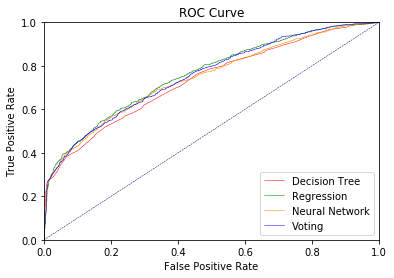

              precision    recall  f1-score   support

       False       0.64      0.75      0.69      1590
        True       0.69      0.58      0.63      1591

   micro avg       0.66      0.66      0.66      3181
   macro avg       0.67      0.66      0.66      3181
weighted avg       0.67      0.66      0.66      3181

              precision    recall  f1-score   support

       False       0.66      0.78      0.71      1590
        True       0.73      0.59      0.65      1591

   micro avg       0.69      0.69      0.69      3181
   macro avg       0.69      0.69      0.68      3181
weighted avg       0.69      0.69      0.68      3181

              precision    recall  f1-score   support

       False       0.66      0.76      0.71      1590
        True       0.72      0.61      0.66      1591

   micro avg       0.68      0.68      0.68      3181
   macro avg       0.69      0.68      0.68      3181
weighted avg       0.69      0.68      0.68      3181

              preci

In [39]:
#ypred_voting = voting.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, ypred_dt[:, 1])
roc_index_reg = roc_auc_score(y_test, ypred_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, ypred_neural[:, 1])
roc_index_vote = roc_auc_score(y_test, y_pred_proba_ensemble[:,1])

plt.plot(fpr_dt, tpr_dt, label='Decision Tree'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='Regression'.format(roc_index_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='Neural Network'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_ens, tpr_ens, label='Voting'.format(roc_index_vote), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(report_dt)
print(report_reg)
print(report_neural)
print(report_ens)

**(a) ROC Chart (and Index)**  
The chart and index shows that ensemble mode has the relative best result, as its index is the higherst in the four models. The second is Neural Network model, then Logical Regression, then decision tree.

**(b) Score Ranking (or Accuracy Score)**  
By comparing the accuracy score, ensemble mode still has the best result, the second is Neural Networ, then decision tree, then Logical Regression.

**(c) Classification report**  
The overall result and f1-score shows the ensemble mode has best performance and the other three results are similar.

**(d) Output**  
This illustrates the ensemble model has the best performance

**(5.2b) Do all the models agree on the cars characteristics? How do they vary?**
Here, we can see the curve for different models. Ensemble Model(voting one) shows the largest curve area compared to the other three models. Thus, all three statistics that we used collectively agreed on Ensemble Model being the best performing model overall.

## Task 6 - Final Remarks: Decision Making
#### 6.1 Finally, based on all models and analysis, is there a particular model you will use in decision making? Justify your choice.
The decision tree might be a better solution for the dealership, even though it does not have the best precision. All the solutions are close in terms of accuracary, and the decision model allow the dealership to use the learning outcome as 'rule of thumb'-tips to improve decision making when making deals. The ensemble model does have a slightly higher accuracy but would recure salesmen to have access to a computer during negotiation and is not precise enough to automate the decision making process.

#### 6.2 Can you summarise positives and negatives of each predictive modelling method based on this analysis?
Regression and decision tree seems to have similar results - the decision tree is however easier to interpret. The neural network had a strong tendency of overfitting and the resulting model was hard to interprete. We believe it would be a better fit for automated tasks where a higher precision can be achieved. A car deal is a longer process and the price is negotiable, so it is important that the 'learning outcomes' of the data mining can be easily conveyed.

#### 6.3 How the outcome of this study can be used by decision makers? 
The outcome can be used as 'rule of thumb' tips and to highlight 'warning signs' when negotiating the price of a car at the dealership. The precision of the models are not high enough to be blindly trusted as automated decision making.